In [203]:
%matplotlib inline
import streamlit as st
import pandas as pd
import datetime
from xgboost import XGBRegressor
import numpy as np
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from pandas.plotting import autocorrelation_plot
from sklearn.linear_model import LinearRegression, MultiTaskLassoCV
from pmdarima.arima import auto_arima
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from sklearn.ensemble import VotingRegressor
import jsonpickle
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [41]:
df = pd.read_csv("../data/crime_full_filtered.csv")

# Drop unused columns
df = df.drop(
    [
        "Unnamed: 0",
        "ID",
        "Case Number",
        "Block",
        "IUCR",
        "Description",
        "Arrest",
        "Domestic",
        "Beat",
        "District",
        "Ward",
        "Community Area",
        "FBI Code",
        "Year_x",
        "Year_y",
        "X Coordinate",
        "Y Coordinate",
        "Year_x",
        "Updated On",
        "feelslikemax",
        "feelslikemin",
        "feelslike",
        "FullMoonDates",
        "icon",
        "stations",
        "name",
        "datetime",
        "precipprob",
        "precipcover",
        "preciptype",
        "dew",
        "windgust",
        "windspeed",
        "winddir",
        "sealevelpressure",
        "cloudcover",
        "visibility",
        "solarradiation",
        "solarenergy",
        "uvindex",
        "severerisk",
        "moonphase",
        "humidity",
        "precip",
        "snow",
        "snowdepth",
        "sunrise",
        "sunset",
        "description",
        "Location",
        "Location Description",
    ],
    axis=1,
).copy()

# change date column to date time object


df["Date"] = pd.to_datetime(df["Date"])

# pull out day of the week and do a sine cosine transform on it to make cyclical features


df["Day of Week"] = df["Date"].dt.day_of_week
df["Day of Week Sin"] = np.sin(df["Day of Week"])
df["Day of Week Cos"] = np.cos(df["Day of Week"])
df.drop(["Day of Week"], axis=1, inplace=True)

# Replace holiday NA with the string "None"
df["Holiday"] = df["Holiday"].fillna("None")

# Sort the dataset by date


df = df.sort_values(by="DateTime").reset_index(drop=True)

# only take the datapoints after 2009 (we dont have weather data before then)


df = df.loc[df["Date"] >= "2010-01-01"]

# rename the datetime column to just time and only keep time without date


df.rename(columns={"DateTime": "Time"}, inplace=True)


df["Time"] = pd.to_datetime(df["Time"])


df["Time"] = df["Time"].dt.time


# one hot encode the conditions column


df = pd.concat(
    [df.drop(["conditions"], axis=1), df["conditions"].str.get_dummies(sep=", ")],
    axis=1,
)
df.dropna(inplace=True)

# Create a categorical variable from the time column all in 6 hour intervals
# morning: 5 am to 11 am
# afternoon: 11 am to 5 pm
# evening: 5pm to 11 pm
# night: 11 pm to 5 am
morning_start = datetime.time(5, 0)
morning_end = datetime.time(10, 59)
df.loc[(df["Time"] >= morning_start) & (df["Time"] <= morning_end), "TimeOfDay"] = (
    "morning"
)

afternoon_start = datetime.time(11, 0)
afternoon_end = datetime.time(16, 59)
df.loc[(df["Time"] >= afternoon_start) & (df["Time"] <= afternoon_end), "TimeOfDay"] = (
    "afternoon"
)

evening_start = datetime.time(17, 0)
evening_end = datetime.time(22, 59)
df.loc[(df["Time"] >= evening_start) & (df["Time"] <= evening_end), "TimeOfDay"] = (
    "evening"
)

night_start = datetime.time(23, 0)
night_end = datetime.time(4, 59)
df.loc[(df["Time"] >= night_start) | (df["Time"] <= night_end), "TimeOfDay"] = "night"

df.drop(["Time"], axis=1, inplace=True)


# one hot encode the holiday variable
df = pd.concat([df.drop(["Holiday"], axis=1), pd.get_dummies(df["Holiday"])], axis=1)
# df = pd.concat([df.drop(["TimeOfDay"], axis=1), pd.get_dummies(df["TimeOfDay"])], axis=1)
# df = pd.concat(
#     [df.drop(["Day of Week"], axis=1), pd.get_dummies(df["Day of Week"])], axis=1
# )

# create sine and cosine variables of the month
df["Month"] = df["Date"].dt.month
df["Month Sin"] = np.sin(df["Month"])
df["Month Cos"] = np.cos(df["Month"])
df.drop(["Month"], axis=1, inplace=True)

C:\Users\gmspr\AppData\Local\Temp\ipykernel_7448\2929029130.py:1: DtypeWarning: Columns (24,25,26,28,29,41,54,55,57,58,59,60) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("../data/crime_full_filtered.csv")


In [42]:
df

,Date,Primary Type,Latitude,Longitude,tempmax,tempmin,temp,Day of Week Sin,Day of Week Cos,Clear,...,Independence Day,Martin Luther King Jr. Day,Memorial Day,New Year's Day,New Year's Eve,None,Presidents' Day,Valentine's Day,Month Sin,Month Cos
76242,2010-01-01,CRIM SEXUAL ASSAULT,41.871437,-87.719700,-8.3,-14.5,-11.7,-0.756802,-0.653644,0,...,False,False,False,True,False,False,False,False,0.841471,0.540302
76243,2010-01-01,CRIM SEXUAL ASSAULT,41.874346,-87.726406,-8.3,-14.5,-11.7,-0.756802,-0.653644,0,...,False,False,False,True,False,False,False,False,0.841471,0.540302
76244,2010-01-01,BATTERY,41.880991,-87.704696,-8.3,-14.5,-11.7,-0.756802,-0.653644,0,...,False,False,False,True,False,False,False,False,0.841471,0.540302
76247,2010-01-01,SEX OFFENSE,41.867000,-87.730775,-8.3,-14.5,-11.7,-0.756802,-0.653644,0,...,False,False,False,False,False,True,False,False,0.841471,0.540302
76248,2010-01-01,ASSAULT,41.875439,-87.712171,-8.3,-14.5,-11.7,-0.756802,-0.653644,0,...,False,False,False,False,False,True,False,False,0.841471,0.540302
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159056,2024-02-24,ASSAULT,41.878858,-87.726595,1.6,-4.7,-1.2,-0.958924,0.283662,0,...,False,False,False,False,False,True,False,False,0.909297,-0.416147
159057,2024-02-24,BATTERY,41.879783,-87.723906,1.6,-4.7,-1.2,-0.958924,0.283662,0,...,False,False,False,False,False,True,False,False,0.909297,-0.416147
159058,2024-02-24,BATTERY,41.871053,-87.697138,1.6,-4.7,-1.2,-0.958924,0.283662,0,...,False,False,False,False,False,True,False,False,0.909297,-0.416147
159059,2024-02-24,BATTERY,41.876228,-87.721597,1.6,-4.7,-1.2,-0.958924,0.283662,0,...,False,False,False,False,False,True,False,False,0.909297,-0.416147


In [43]:
df_pivot_type = df.pivot_table(
    index="Date", columns="Primary Type", aggfunc="size", fill_value=0
)

df_pivot_time = df.pivot_table(
    index="Date", columns="TimeOfDay", aggfunc="size", fill_value=0
)

df_by_date = df.groupby("Date").mean(
    [
        "tempmax",
        "tempmin",
        "temp",
        "Clear",
        "Freezing Drizzle/Freezing Rain",
        "Ice",
        "Overcast",
        "Partially cloudy",
        "Rain",
        "Snow",
        "New Year's Eve",
        "afternoon",
        "Day of Week Sin",
        "Day of Week Cos",
        "Month Sin",
        "Month Cos",
    ]
)

In [80]:
final_df = pd.concat([df_pivot_type, df_pivot_time, df_by_date], axis=1).drop(
    "None", axis=1
)
final_df.loc[final_df["New Year's Day"] > 0, "New Year's Day"] = 1
final_df["Total"] = (
    final_df["afternoon"]
    + final_df["evening"]
    + final_df["morning"]
    + final_df["night"]
)
final_df["Yesterday Total"] = final_df["Total"].shift(1)
final_df.dropna(inplace=True)

X = final_df.drop(
    [
        "ARSON",
        "ASSAULT",
        "BATTERY",
        "CRIM SEXUAL ASSAULT",
        "CRIMINAL SEXUAL ASSAULT",
        "HOMICIDE",
        "KIDNAPPING",
        "RITUALISM",
        "ROBBERY",
        "temp",
        "SEX OFFENSE",
        "afternoon",
        "evening",
        "morning",
        "night",
        "Latitude",
        "Longitude",
        "Total",
        "Presidents' Day",
        "Valentine's Day",
        "Halloween",
        "Independence Day",
        "Martin Luther King Jr. Day",
        "Memorial Day",
        "New Year's Day",
        "Columbus Day",
    ],
    axis=1,
)

X_train = X.head(len(X) - 7)
X_test = X.tail(7)

y = final_df[
    [
        "ARSON",
        "ASSAULT",
        "BATTERY",
        "CRIM SEXUAL ASSAULT",
        "CRIMINAL SEXUAL ASSAULT",
        "HOMICIDE",
        "KIDNAPPING",
        "RITUALISM",
        "ROBBERY",
        "SEX OFFENSE",
        "afternoon",
        "evening",
        "morning",
        "night",
        "Total",
    ]
]

y_train = y.head(len(y) - 7)
y_test = y.tail(7)

In [217]:
linear_regression_model = LinearRegression()
linear_regression_model.fit(X_train, y_train)
line = linear_regression_model.predict(X_train)
linear_regression_residuals = y_train - line

model = XGBRegressor(
    n_estimators=50, gamma=1, subsample=0.7, reg_lambda=3, eval_metric = "rmse"
)

# grid.fit(X_train, y_train)


model.fit(X_train, linear_regression_residuals)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=1, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=50, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [218]:
serialized_linear_regression_model = jsonpickle.encode(linear_regression_model)
model.save_model("xgb_model.model")

with open("linear_regression_model.json", "w") as f:
    f.write(serialized_linear_regression_model)

# Everything below here will be used in the streamlit dashboard

In [219]:
# code to read and decode the model
xgb_model = XGBRegressor()
xgb_model.load_model("xgb_model.model")


with open("linear_regression_model.json", "r") as f:
    serialized_linear_model = f.read()
    linear_model = jsonpickle.decode(serialized_linear_model)

In [220]:
class EnsembleModel:
    def __init__(self, linear_model, xgb_model):
        self.linear_model = linear_model
        self.xgb_model = xgb_model

    def predict(self, X):
        return (self.linear_model.predict(X) + self.xgb_model.predict(X))[0]

In [221]:
total_pred = y_train.tail(1)["Total"].values[0]
preds = []
ensemble_model = EnsembleModel(linear_regression_model, model)
for i in range(len(y_test)):
    day_to_predict = X_test.iloc[i].to_frame().T
    day_to_predict["Yesterday Total"] = total_pred
    total_all_preds = ensemble_model.predict(day_to_predict)
    total_pred = total_all_preds[14]
    prev_day_pred = total_pred
    preds.append(total_all_preds)

preds = np.array(preds)

In [222]:
np.sqrt(mean_squared_error(preds[:, 14], y_test["Total"]))

4.201027575905606

In [223]:
preds_total = preds[:, 14]
preds_arson = preds[:, 0]
preds_assault = preds[:, 1]
preds_battery = preds[:, 2]
preds_sexual_assualt = preds[:, 3] + preds[:, 4] + preds[:, 9]
preds_homicide = preds[:, 5]
preds_kidnapping = preds[:, 6]
preds_ritualism = preds[:, 7]
preds_robbery = preds[:, 8]
preds_afternoon = preds[:, 10]
preds_evening = preds[:, 11]
preds_morning = preds[:, 12]
preds_night = preds[:, 13]

total_calculated_type = (
    preds_arson
    + preds_assault
    + preds_battery
    + preds_sexual_assualt
    + preds_homicide
    + preds_kidnapping
    + preds_ritualism
    + preds_robbery
)
total_calculated_time = preds_morning + preds_afternoon + preds_evening + preds_night

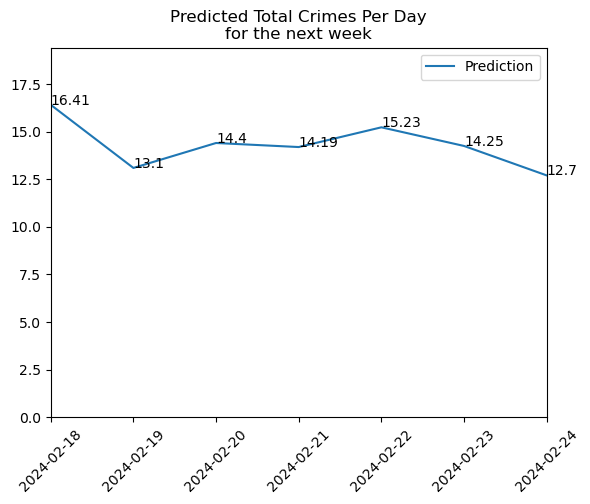

In [54]:
fig, ax = plt.subplots()


ax.plot(X_test.index, preds_total, label="Prediction")


ax.set_xlim(pd.to_datetime("2024-02-18"), pd.to_datetime("2024-02-24"))


ax.legend()
ax.set_title("Predicted Total Crimes Per Day\nfor the next week")
ax.set_ylim(0, max(preds_total) + 3)


plt.xticks(rotation=45)

for point in zip(X_test.index, preds_total):
    plt.annotate(round(point[1], 2), xy=(point))


plt.show()

In [55]:
perc_homicide = (preds_homicide / total_calculated_type) * 100
perc_sexual_assault = (preds_sexual_assualt / total_calculated_type) * 100
perc_arson = (preds_arson / total_calculated_type) * 100
perc_assault = (preds_assault / total_calculated_type) * 100
perc_battery = (preds_battery / total_calculated_type) * 100
perc_kidnapping = (preds_kidnapping / total_calculated_type) * 100
perc_ritualism = (preds_ritualism / total_calculated_type) * 100
perc_robbery = (preds_robbery / total_calculated_type) * 100

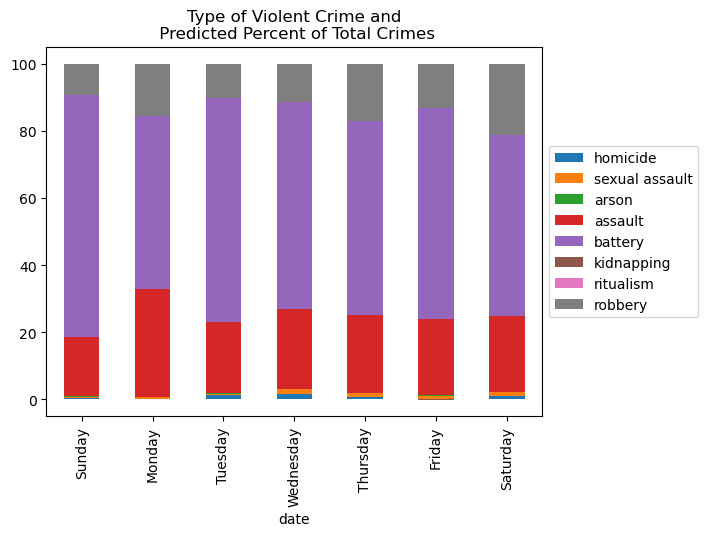

In [56]:
plotdf = pd.DataFrame(
    {
        "date": X_test.index.day_name(),
        "homicide": perc_homicide,
        "sexual assault": perc_sexual_assault,
        "arson": perc_arson,
        "assault": perc_assault,
        "battery": perc_battery,
        "kidnapping": perc_kidnapping,
        "ritualism": perc_ritualism,
        "robbery": perc_robbery,
    }
)
plotdf.set_index("date", inplace=True)
plotdf.plot(kind="bar", stacked=True)
plt.title("Type of Violent Crime and\n Predicted Percent of Total Crimes")
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.show()

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

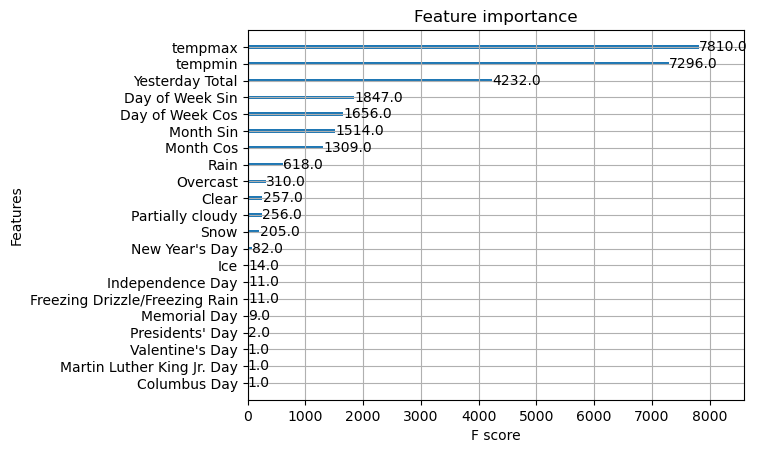

In [58]:
xgb.plot_importance(model)